In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [6]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [7]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size, seq_len):
#     length = datapoint_per_second * duration
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments, segments


def overlap_split(df, chunk_size, seq_len):
    cks = chunk_size + 1
    half_len = int(seq_len / 2)
    length = cks * half_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    split_segs = []
    ck_id = np.zeros((chunk_size, 2), dtype=int)
    ck_id[:, 0] = np.arange(chunk_size)
    ck_id[:, 1] = ck_id[:, 0] + 1
    
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        split_seg = np.array(np.split(seg, cks))

        segments.append(split_seg[ck_id].reshape(chunk_size, seq_len, -1))
        split_segs.append(split_seg)
        
    return segments, split_segs
    

def select_data(df):
    return df[['acc_x', 'acc_y', 'acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25):
    pre_df = select_data(df)
    segs, split_seg = overlap_split(pre_df, chunk_size, seq_len)
    
    return segs, split_seg

In [8]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs, source_splits = preprocess_data(source_df, chunk_size, seq_len)
        target_segs, target_splits = preprocess_data(target_df, chunk_size, seq_len)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags, source_splits[:idx], target_splits[:idx]))
        
    return pair_data

In [9]:
datapoint_per_second = 20
duration = 2
chunk_size = 20
seq_len = 24
classes = {'target': 0, 'front_pocket': 1, 'pocket': 2, 'swing': 3}

In [10]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [11]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./front_pocket/202302071724
./front_pocket/202302071724/source ./front_pocket/202302071724/target
./pocket/20230213210

In [12]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

226 213 210


In [13]:
front_pocket_pair_data[0][0][0, -1], front_pocket_pair_data[0][2][0, -1]

(array([-3.89924149e+00,  1.56013069e+01,  9.66989136e-02, -3.46604615e-01,
        -1.22895777e+00,  5.17699718e-01,  1.15293147e+00,  1.78475031e+00,
        -1.25223210e+00,  1.02946167e+01, -1.43725891e+01,  4.03854370e+01,
         1.67575812e+09]),
 array([-9.11454620e-01,  9.59669357e+00,  5.45929733e+00,  1.94446683e-01,
        -3.76825482e-02, -4.20625433e-02, -3.26001422e-01,  1.31789166e+00,
         7.59824039e-01, -3.69051743e+01,  1.47752380e+00, -2.53529663e+01,
         1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
# class ClassDataset(Dataset):
#     def __init__(self, data, label):
#         self.data = data
#         self.label = label

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.label[idx]

In [16]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label, source_split=None, target_split=None):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label
        self.source_split = source_split
        self.target_split = target_split

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx], self.source_split[idx], self.target_split[idx]

In [17]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [18]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Conv1d(9, 16, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * (seq_len - 8), hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = torch.reshape(x, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.permute(h, (0, 2, 1))  # (bs * chunk_size, seq_len, 9) -> (bs * chunk_size, 9, seq_len) [CNN要對最後一個維度做卷積]
        
        h = self.cnn(h)

        h = torch.permute(h, (0, 2, 1))
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.pos_encoder = PositionalEncoding(64 * self.seq_len, 0.1)
        
        ################
        ### Imu Part ###
        ################
        #self.classifier = Classifier(chunk_size, seq_len, num_of_classes)
        
        ################
        ### Mag Part ###
        ################
        self.imu_embedding = nn.Sequential(
            nn.Linear(9, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU()
        )
        
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        
        self.mag_transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.2, batch_first=True), num_layers=8)
        self.mag_transformer_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.2, batch_first=True), num_layers=8)
        self.mag_last = nn.Sequential(
            nn.Linear(64 * self.seq_len, 16 * self.seq_len),
            nn.GELU(),
            nn.Linear(16 * self.seq_len, 3 * self.seq_len),
        )
        
    def forward(self, source_imu, source_mag, target_mag=None):

        if target_mag != None:
            ################
            ### imu part ###
            ################
#             source_h = self.imu_layer(source_imu)
#             source_hz, _ = self.imu_rnn(source_h)
#             source_predict_probability = self.imu_last(source_hz[:, -1])

            ################
            ### mag part ###
            ################
            source_mag_h = self.mag_layer(source_mag)  # (batch, chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 64)
            source_mag_h = torch.reshape(source_mag_h, (len(source_mag), self.chunk_size, -1))  # (batch, chunk_size, seq_len, 64) -> (batch, chunk_size, seq_len * 64)
            res_source_mag = source_mag_h
            source_mag_h = self.pos_encoder(source_mag_h)  # (batch, chunk_size, seq_len * 64)
            source_imu_h = self.imu_embedding(source_imu)
            source_imu_h = torch.reshape(source_imu_h, (len(source_imu), self.chunk_size, -1))
            source_mag_h += source_imu_h
            
            target_mag = torch.concat([torch.zeros(len(target_mag), 1, self.seq_len, 3).to(source_mag.device), target_mag], dim=1)
            tgt = self.mag_layer(target_mag)  # (batch, chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 64)
            tgt = torch.reshape(tgt, (len(source_mag), self.chunk_size, -1))  # (batch, chunk_size, seq_len, 64) -> (batch, chunk_size, seq_len * 64)
            tgt = self.pos_encoder(tgt)  # (batch, chunk_size, seq_len * 64)
            
            source_mag_hz = self.mag_transformer_encoder(source_mag_h)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 64)
#             source_latent = torch.add(source_hz, source_mag_hz)  # (batch, chunk_size, 48)
            tgt_mask = get_tgt_mask(self.chunk_size).to(source_mag.device)
            mem_mask = get_tgt_mask(self.chunk_size).to(source_mag.device)
            predict_mag_latent = self.mag_transformer_decoder(tgt, source_mag_hz, tgt_mask, mem_mask)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 64)
            predict_mag = self.mag_last(predict_mag_latent+res_source_mag)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 3)
            predict_mag = torch.reshape(predict_mag, (len(source_mag), self.chunk_size, self.seq_len, -1))  # (batch * chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 3)

            return predict_mag
        
        else:
            ################
            ### imu part ###
            ################
#             source_h = self.imu_layer(source_imu)
#             source_hz, _ = self.imu_rnn(source_h)
#             source_predict_probability = self.imu_last(source_hz[:, -1])

            ################
            ### mag part ###
            ################
            source_mag_h = self.mag_layer(source_mag)  # (batch, chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 64)
            source_mag_h = torch.reshape(source_mag_h, (len(source_mag), self.chunk_size, -1))  # (batch, chunk_size, seq_len, 64) -> (batch, chunk_size, seq_len * 64)
            res_source_mag = source_mag_h
            source_mag_h = self.pos_encoder(source_mag_h)  # (batch, chunk_size, seq_len * 64)
            source_imu_h = self.imu_embedding(source_imu)
            source_imu_h = torch.reshape(source_imu_h, (len(source_imu), self.chunk_size, -1))
            source_mag_h += source_imu_h
            source_mag_hz= self.mag_transformer_encoder(source_mag_h)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 64)

#             source_latent = torch.add(source_hz, source_mag_hz)  # (batch, chunk_size, 48)
            tgt = torch.zeros(len(source_mag), 1, self.seq_len, 3).to(source_mag.device)
            tgt = self.mag_layer(tgt)  # (batch, chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 64)
            tgt = torch.reshape(tgt, (len(source_mag), 1, -1))
        
            for i in range(source_mag_hz.size(1)):
#                 tgt_pos = self.pos_encoder(torch.zeros(source_mag_hz.size(0), 1, source_mag_hz.size(-1)).to(source_mag_hz.device) + i)
                tgt_pos = self.pos_encoder(tgt.clone())
                tgt_mask = get_tgt_mask(tgt.size(1)).to(source_mag.device)
#                 decode_position = self.mag_transformer_decoder(tgt_pos[:, max(0, i-5):, :], source_mag_hz[:, max(0, i-5):i+1, :], tgt_mask[:, max(0, i-5):, :], tgt_mask[:, max(0, i-5):, :], memory_key_padding_mask=None)
                decode_position = self.mag_transformer_decoder(tgt_pos, source_mag_hz[:, :i+1, :], tgt_mask, tgt_mask, memory_key_padding_mask=None)
                tgt = torch.concat([tgt, decode_position[:, -1:]], dim=1)
            tgt[:, 1:] += res_source_mag
            predict_mag = self.mag_last(tgt)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 3)
            predict_mag = torch.reshape(predict_mag, (len(source_mag), self.chunk_size + 1, self.seq_len, -1))  # (batch * chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 3)
            
            return predict_mag[:, 1:]


In [19]:
class Discriminator(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21):
        super(Discriminator, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 32),
            nn.LeakyReLU(),
        )
        
        self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
        self.discriminant_layer = nn.Sequential(
            nn.Linear(64 * self.seq_len, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
        h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
        hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
        out = self.discriminant_layer(hz)
        
        return out

In [20]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', chunk_size=5):
        super(FirstDerivativeLoss, self).__init__()
        self.chunk_size = chunk_size

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), self.chunk_size, -1))
        target_o = torch.reshape(target, (len(target), self.chunk_size, -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [33]:
def generator_loss(gt_mag, pred_mag, d_res):
    pred_loss = mse_loss(pred_mag, gt_mag)
    d_loss = bce_loss(d_res, torch.ones_like(d_res))
    d1_loss = div_loss(pred_mag, gt_mag)
    weight = [[1, 3], [2, 2], [3, 1]]
    delta = math.floor(math.log10(pred_loss.item()))

    return pred_loss * weight[delta][0] + d_loss*50 + d1_loss * weight[delta][1], pred_loss, d1_loss

def discriminator_loss(d_real, d_fake):
    real_loss = bce_loss(d_real, torch.ones_like(d_real))
    fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

    return real_loss + fake_loss

In [34]:
front_pocket_half = int(len(front_pocket_pair_data) * 0.8)
pocket_half = int(len(pocket_pair_data) * 0.8)
swing_half = int(len(swing_pair_data) * 0.8)

train_data = front_pocket_pair_data[:front_pocket_half] + pocket_pair_data[:pocket_half] + swing_pair_data[:swing_half]
valid_data = front_pocket_pair_data[front_pocket_half:] + pocket_pair_data[pocket_half:] + swing_pair_data[swing_half:]

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                    source_split = torch.tensor(np.array([d[4] for d in train_data]), dtype=torch.float),
                    target_split = torch.tensor(np.array([d[5] for d in train_data]), dtype=torch.float),
                )
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                    source_split = torch.tensor(np.array([d[4] for d in valid_data]), dtype=torch.float),
                    target_split = torch.tensor(np.array([d[5] for d in valid_data]), dtype=torch.float),
                )
valid_loader = DataLoader(valid_dataset, batch_size=64)

In [35]:
batch = next(iter(train_loader))

In [36]:
# batch

In [37]:
EPOCH = 2000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss(chunk_size=chunk_size+1)

In [38]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
discriminator = Discriminator(chunk_size=chunk_size + 1, seq_len=int(seq_len/2)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [39]:
def plot_result(result):
    cks = len(result[0])
    sl = len(result[0][0])
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, cks+1):
        plt.axvline(x=int(i * sl - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [40]:
def fusion(pred_mags):
    cks = chunk_size + 1
    half_len = int(seq_len / 2)
    fusion_mags = torch.zeros(len(pred_mags), cks, half_len, 3).to(pred_mags.device)
    
    for i in range(cks - 1):
        fusion_mags[:, i:i+2] += pred_mags[:, i].reshape(len(pred_mags), 2, half_len, 3)
        
    fusion_mags[:, 1:cks-1] = fusion_mags[:, 1:cks-1] / 2
    return fusion_mags

In [41]:
def train(dataloader, draw=False):
    model.train()

    pred_losses = []
    g_losses = []
    d_losses = []
    d1_losses = []

    for source_data, source_label, target_data, target_label, source_split, target_split in tqdm(dataloader):
        optimizer.zero_grad()

        source_data = source_data.to(device)
        target_data = target_data.to(device)
        target_split = target_split.to(device)

        one_hot = F.one_hot(source_label, num_classes=num_of_classes).to(device).float()

        # generate mag
        predict_mag = model(source_data[:, :, :, :9], source_data[:, :, :, 9:12], target_data[:, :-1, :, 9:12])
        predict_mag = fusion(predict_mag)
        
        # generator loss
        d_res = discriminator(predict_mag)
        gen_loss, pred_loss, d1_loss = generator_loss(target_split[:, :, :, 9:12], predict_mag, d_res)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # discriminator loss
        d_real = discriminator(target_split[:, :, :, 9:12])
        d_fake = discriminator(predict_mag.detach())
        dis_loss = discriminator_loss(d_real, d_fake)

        # backward
        dis_loss.backward()
        optimizer_D.step()
        
        # record loss
        pred_losses.append(pred_loss.item())
        g_losses.append(gen_loss.item())
        d1_losses.append(d1_loss.item())
        d_losses.append(dis_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_split[0, :, :, 9:12].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(pred_losses), np.mean(g_losses), np.mean(d1_losses), np.mean(d_losses)

In [42]:
def evalute(dataloader, draw=False):
    model.eval()

    pred_losses = []
    d1_losses = []
    g_losses = []
    d_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label, source_split, target_split in dataloader:
            source_data = source_data.to(device)
            target_data = target_data.to(device)
            target_split = target_split.to(device)
            
            one_hot = F.one_hot(source_label, num_classes=num_of_classes).to(device).float()

            # generate mag
            predict_mag = model(source_data[:, :, :, :9], source_data[:, :, :, 9:12])
            predict_mag = fusion(predict_mag)
            
            # generator loss
            d_res = discriminator(predict_mag)
            gen_loss, pred_loss, d1_loss= generator_loss(target_split[:, :, :, 9:12], predict_mag, d_res)

            # discriminator loss
            d_real = discriminator(target_split[:, :, :, 9:12])
            d_fake = discriminator(predict_mag.detach())
            dis_loss = discriminator_loss(d_real, d_fake)

            # record loss
            pred_losses.append(pred_loss.item())
            g_losses.append(gen_loss.item())
            d1_losses.append(d1_loss.item())
            d_losses.append(dis_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_split[0, :, :, 9:12].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(pred_losses), np.mean(g_losses), np.mean(d1_losses), np.mean(d_losses)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.75it/s]


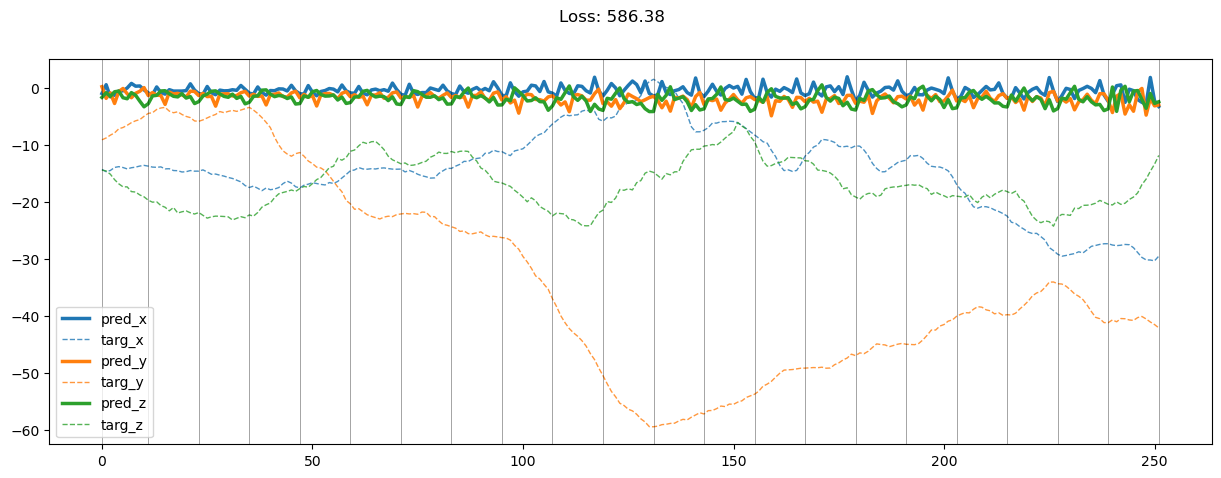

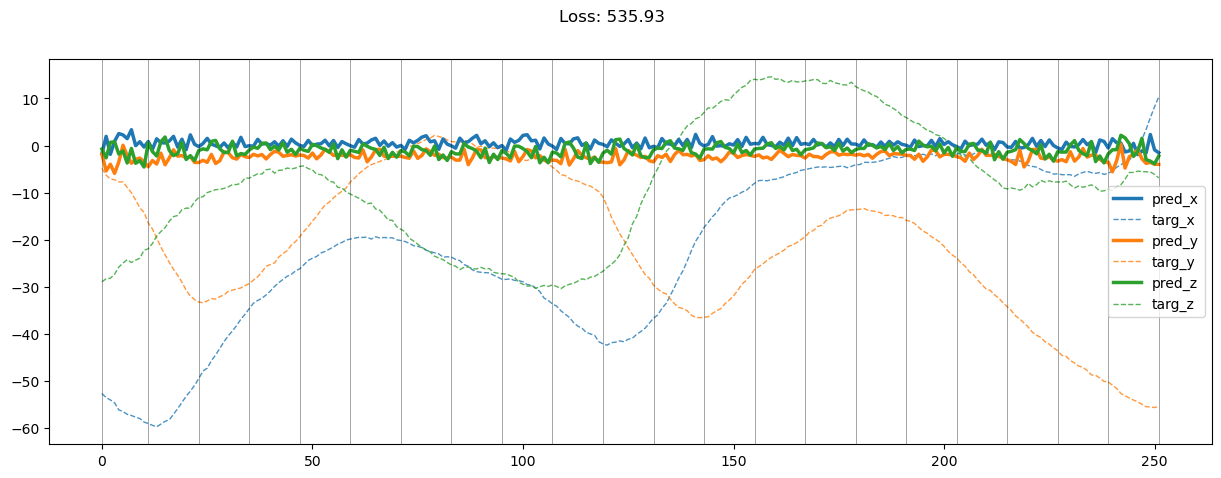

00000: train pred loss:  646.225, g loss:  2941.850, diff loss:  968.495, d loss:  1.352
       valid pred loss:  628.535, g loss:  2700.705, diff loss:  781.368, d loss:  1.334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.92it/s]


00001: train pred loss:  617.689, g loss:  2816.014, diff loss:  930.401, d loss:  1.321
       valid pred loss:  603.189, g loss:  2610.840, diff loss:  770.354, d loss:  1.313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.91it/s]


00002: train pred loss:  573.909, g loss:  2671.003, diff loss:  920.183, d loss:  1.314
       valid pred loss:  580.194, g loss:  2533.544, diff loss:  766.322, d loss:  1.328


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.90it/s]


00003: train pred loss:  535.733, g loss:  2466.457, diff loss:  835.980, d loss:  1.385
       valid pred loss:  550.826, g loss:  2411.692, diff loss:  740.566, d loss:  1.505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.90it/s]


00004: train pred loss:  499.975, g loss:  2349.632, diff loss:  833.928, d loss:  1.604
       valid pred loss:  509.419, g loss:  2279.134, diff loss:  739.780, d loss:  1.853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.83it/s]


00005: train pred loss:  455.942, g loss:  2112.233, diff loss:  736.079, d loss:  2.095
       valid pred loss:  494.936, g loss:  2228.510, diff loss:  738.714, d loss:  2.526


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.82it/s]


00006: train pred loss:  407.394, g loss:  1967.731, diff loss:  741.923, d loss:  2.853
       valid pred loss:  451.229, g loss:  2072.149, diff loss:  716.388, d loss:  3.358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.78it/s]


00007: train pred loss:  384.726, g loss:  1858.657, diff loss:  702.937, d loss:  3.692
       valid pred loss:  433.245, g loss:  1990.985, diff loss:  690.311, d loss:  4.154


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.80it/s]


00008: train pred loss:  349.849, g loss:  1701.408, diff loss:  651.154, d loss:  4.474
       valid pred loss:  461.458, g loss:  2085.436, diff loss:  700.607, d loss:  4.893


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.81it/s]


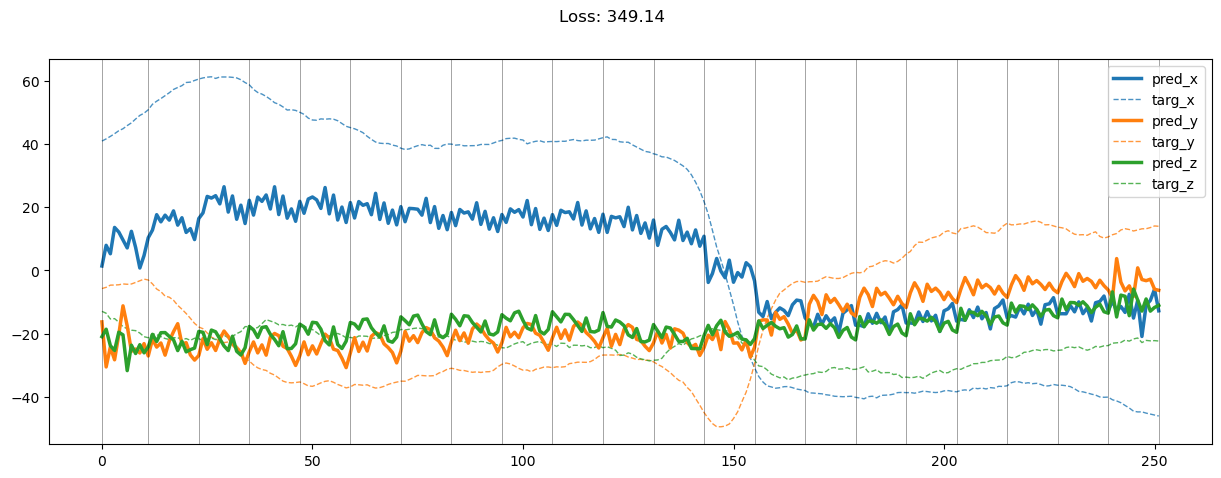

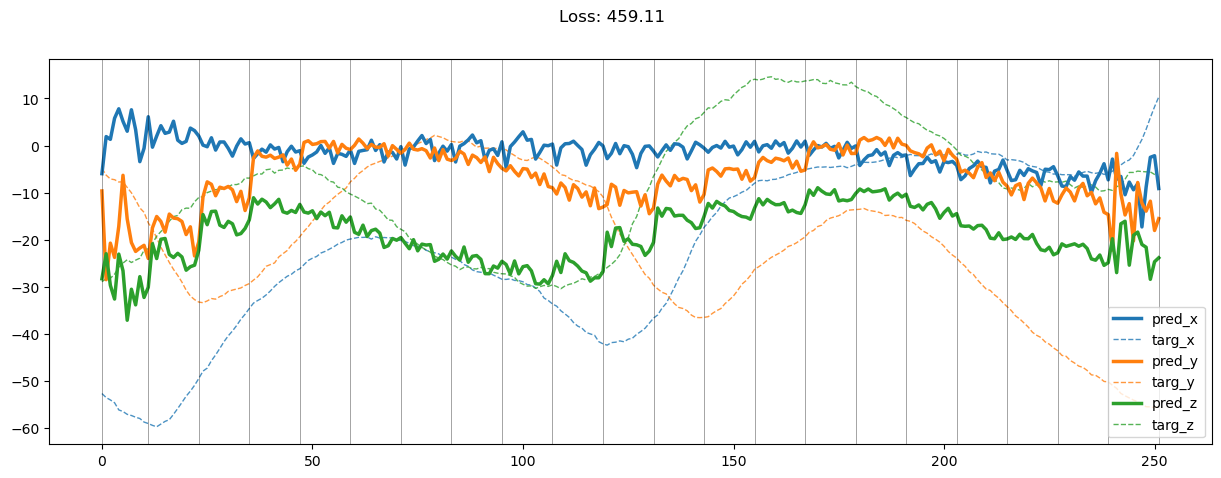

00009: train pred loss:  315.713, g loss:  1530.778, diff loss:  583.274, d loss:  5.147
       valid pred loss:  480.802, g loss:  2137.530, diff loss:  694.873, d loss:  5.494


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.70it/s]


00010: train pred loss:  282.631, g loss:  1394.233, diff loss:  546.129, d loss:  5.688
       valid pred loss:  392.251, g loss:  1815.623, diff loss:  638.709, d loss:  5.954


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.77it/s]


00011: train pred loss:  257.193, g loss:  1287.869, diff loss:  516.150, d loss:  6.098
       valid pred loss:  365.073, g loss:  1708.021, diff loss:  612.683, d loss:  6.255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.73it/s]


00012: train pred loss:  227.251, g loss:  1132.752, diff loss:  450.894, d loss:  6.376
       valid pred loss:  363.088, g loss:  1709.528, diff loss:  620.173, d loss:  6.487


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.62it/s]


00013: train pred loss:  206.828, g loss:  1031.043, diff loss:  410.476, d loss:  6.559
       valid pred loss:  310.116, g loss:  1467.383, diff loss:  536.957, d loss:  6.622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.63it/s]


00014: train pred loss:  186.091, g loss:  926.493, diff loss:  368.147, d loss:  6.663
       valid pred loss:  361.731, g loss:  1737.155, diff loss:  651.891, d loss:  6.703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.51it/s]


00015: train pred loss:  168.704, g loss:  835.937, diff loss:  329.756, d loss:  6.713
       valid pred loss:  286.066, g loss:  1368.204, diff loss:  509.938, d loss:  6.723


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.78it/s]


00016: train pred loss:  155.322, g loss:  781.626, diff loss:  315.590, d loss:  6.717
       valid pred loss:  355.502, g loss:  1599.765, diff loss:  533.190, d loss:  6.708


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.76it/s]


00017: train pred loss:  143.234, g loss:  713.438, diff loss:  283.666, d loss:  6.684
       valid pred loss:  285.418, g loss:  1365.622, diff loss:  509.296, d loss:  6.650


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.76it/s]


00018: train pred loss:  139.016, g loss:  685.788, diff loss:  268.667, d loss:  6.616
       valid pred loss:  313.742, g loss:  1596.137, diff loss:  654.833, d loss:  6.563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.76it/s]


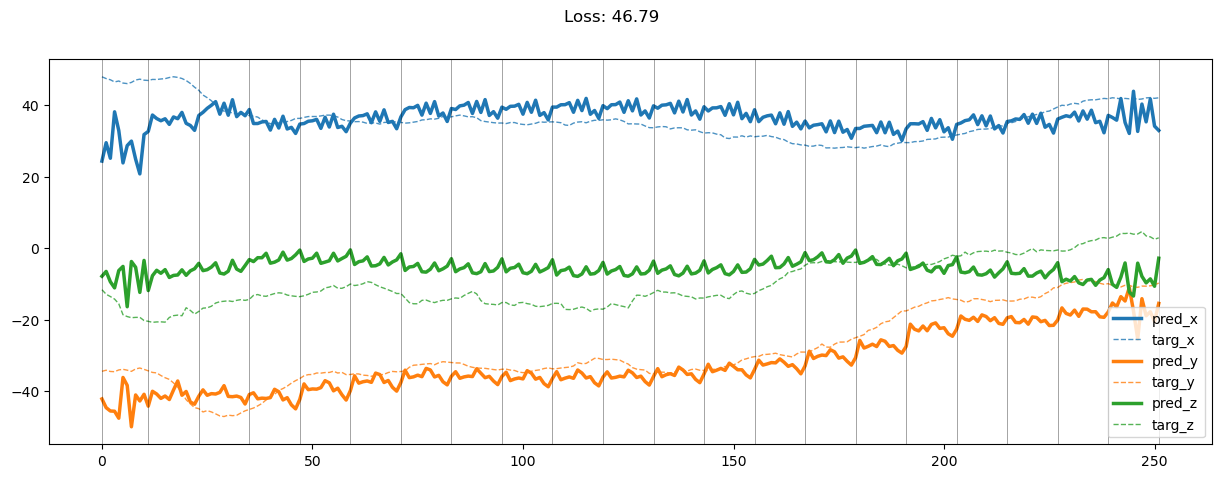

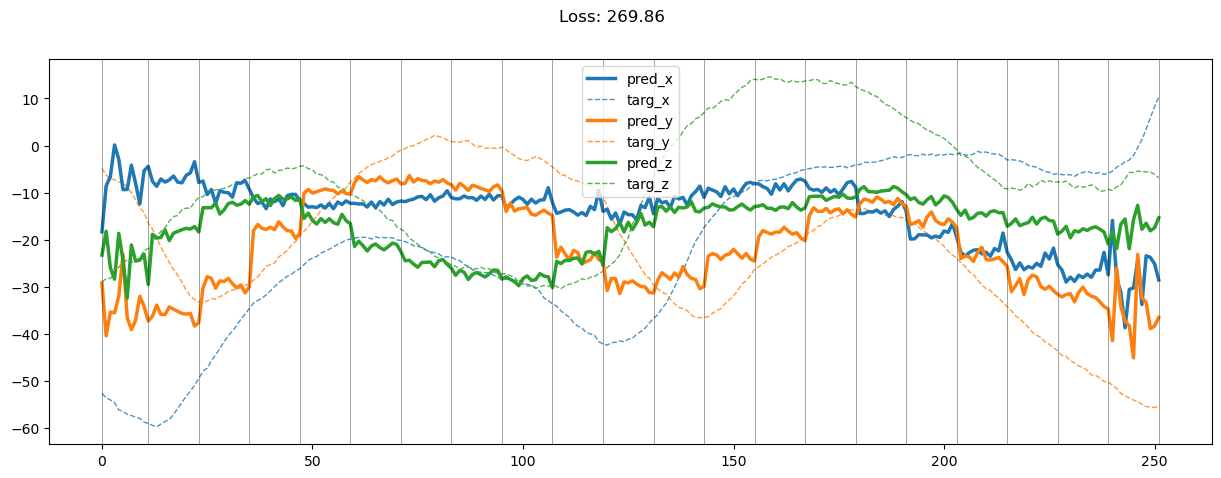

00019: train pred loss:  120.127, g loss:  607.697, diff loss:  234.839, d loss:  6.521
       valid pred loss:  268.937, g loss:  1300.020, diff loss:  493.125, d loss:  6.468


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.73it/s]


00020: train pred loss:  114.741, g loss:  571.657, diff loss:  227.345, d loss:  6.407
       valid pred loss:  289.173, g loss:  1408.755, diff loss:  541.141, d loss:  6.328


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.74it/s]


00021: train pred loss:  110.508, g loss:  545.568, diff loss:  213.942, d loss:  6.274
       valid pred loss:  346.713, g loss:  1651.617, diff loss:  611.373, d loss:  6.208


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.69it/s]


00022: train pred loss:  96.231, g loss:  541.629, diff loss:  185.466, d loss:  6.130
       valid pred loss:  265.266, g loss:  1277.291, diff loss:  481.368, d loss:  6.039


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.60it/s]


00023: train pred loss:  92.104, g loss:  504.630, diff loss:  169.076, d loss:  5.971
       valid pred loss:  340.972, g loss:  1508.489, diff loss:  485.425, d loss:  5.875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.60it/s]


00024: train pred loss:  92.800, g loss:  519.874, diff loss:  177.406, d loss:  5.801
       valid pred loss:  339.972, g loss:  1589.583, diff loss:  569.494, d loss:  5.706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.52it/s]


00025: train pred loss:  87.555, g loss:  496.922, diff loss:  164.677, d loss:  5.623
       valid pred loss:  314.158, g loss:  1533.937, diff loss:  591.254, d loss:  5.524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.41it/s]


00026: train pred loss:  83.459, g loss:  473.603, diff loss:  158.785, d loss:  5.436
       valid pred loss:  275.627, g loss:  1311.487, diff loss:  484.354, d loss:  5.332


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.49it/s]


00027: train pred loss:  73.848, g loss:  428.829, diff loss:  140.429, d loss:  5.245
       valid pred loss:  327.792, g loss:  1462.592, diff loss:  478.914, d loss:  5.145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.41it/s]


00028: train pred loss:  70.930, g loss:  409.513, diff loss:  133.660, d loss:  5.053
       valid pred loss:  273.358, g loss:  1310.747, diff loss:  490.304, d loss:  4.941


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.45it/s]


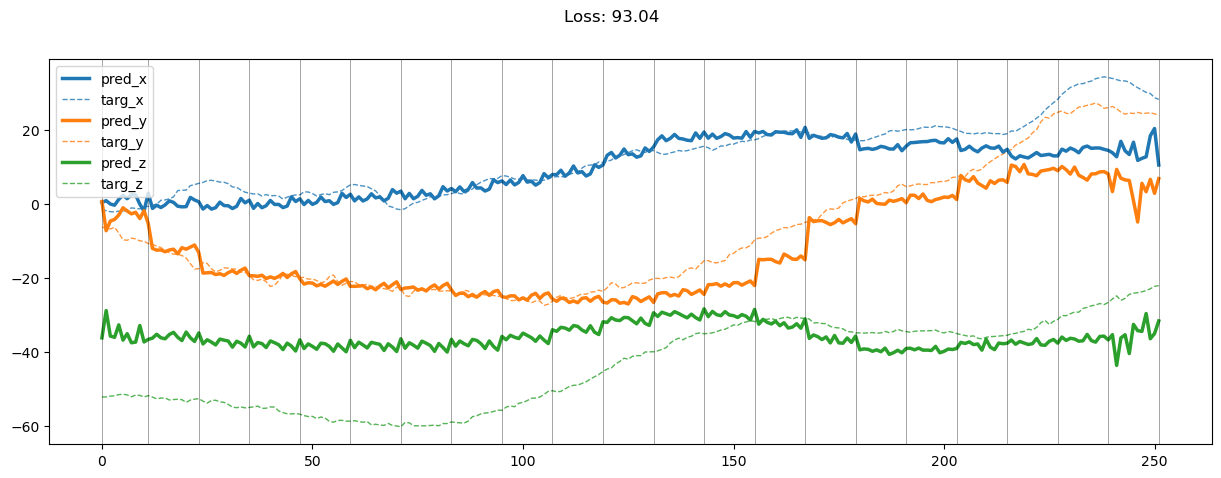

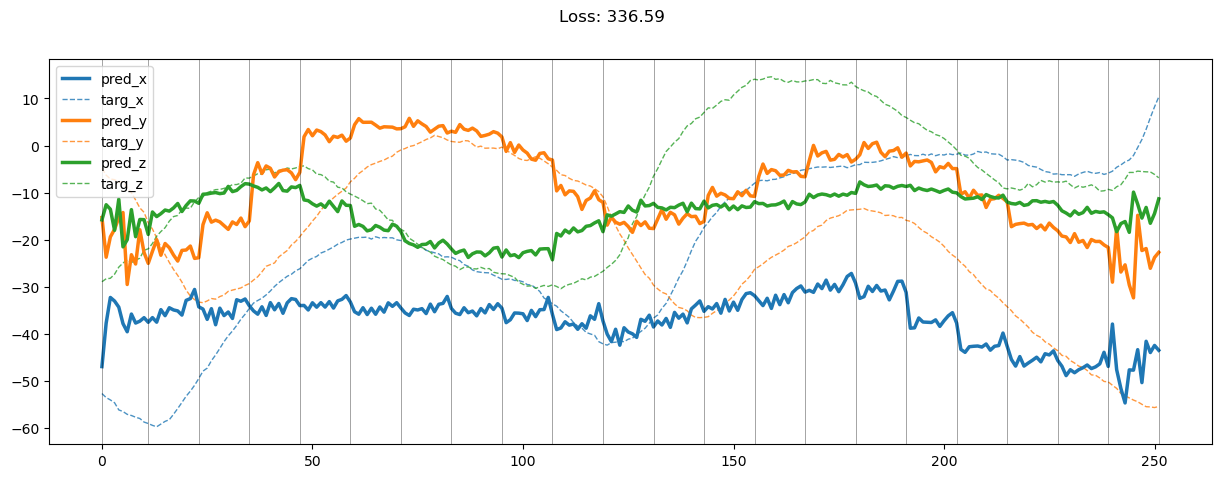

00029: train pred loss:  65.686, g loss:  379.809, diff loss:  124.016, d loss:  4.857
       valid pred loss:  289.348, g loss:  1366.348, diff loss:  497.856, d loss:  4.748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.50it/s]


00030: train pred loss:  63.220, g loss:  364.036, diff loss:  118.554, d loss:  4.665
       valid pred loss:  269.355, g loss:  1306.595, diff loss:  497.987, d loss:  4.558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.25it/s]


00031: train pred loss:  58.707, g loss:  345.837, diff loss:  113.916, d loss:  4.477
       valid pred loss:  296.005, g loss:  1358.693, diff loss:  470.024, d loss:  4.376


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.59it/s]


00032: train pred loss:  57.965, g loss:  331.322, diff loss:  107.341, d loss:  4.295
       valid pred loss:  304.307, g loss:  1488.192, diff loss:  574.490, d loss:  4.197


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.48it/s]


00033: train pred loss:  54.420, g loss:  319.100, diff loss:  104.706, d loss:  4.120
       valid pred loss:  262.397, g loss:  1274.585, diff loss:  486.465, d loss:  4.027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.17it/s]


00034: train pred loss:  52.108, g loss:  305.027, diff loss:  99.905, d loss:  3.956
       valid pred loss:  312.217, g loss:  1504.996, diff loss:  567.251, d loss:  3.866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.15it/s]


00035: train pred loss:  52.671, g loss:  310.891, diff loss:  102.189, d loss:  3.803
       valid pred loss:  250.192, g loss:  1225.076, diff loss:  473.230, d loss:  3.723


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.45it/s]


00036: train pred loss:  50.090, g loss:  292.424, diff loss:  95.447, d loss:  3.663
       valid pred loss:  272.948, g loss:  1319.000, diff loss:  498.698, d loss:  3.588


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.43it/s]


00037: train pred loss:  48.202, g loss:  280.572, diff loss:  91.315, d loss:  3.538
       valid pred loss:  245.030, g loss:  1190.562, diff loss:  453.831, d loss:  3.475


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.51it/s]


00038: train pred loss:  47.366, g loss:  278.016, diff loss:  90.781, d loss:  3.430
       valid pred loss:  269.781, g loss:  1306.815, diff loss:  495.651, d loss:  3.376


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.59it/s]


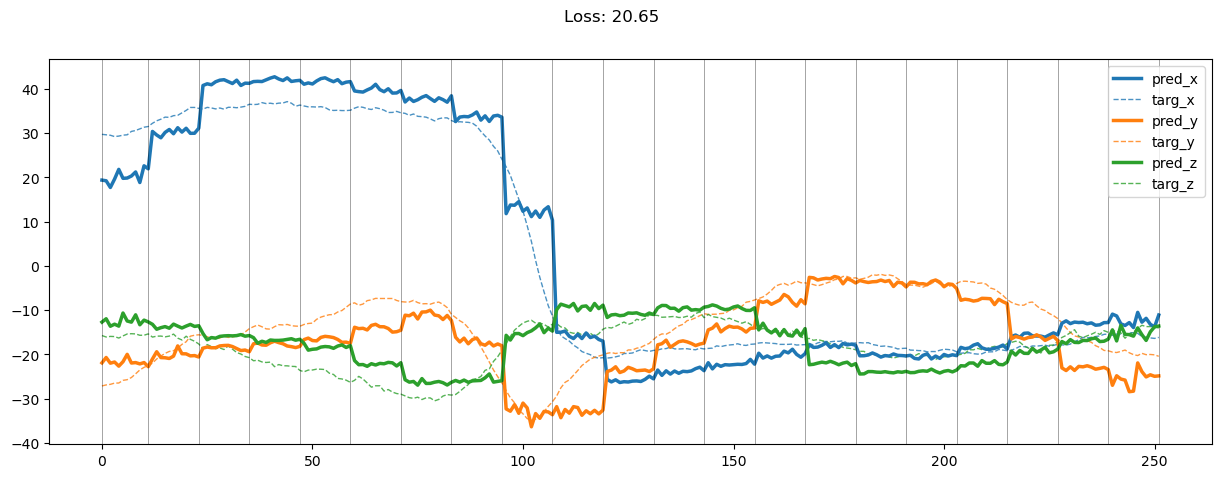

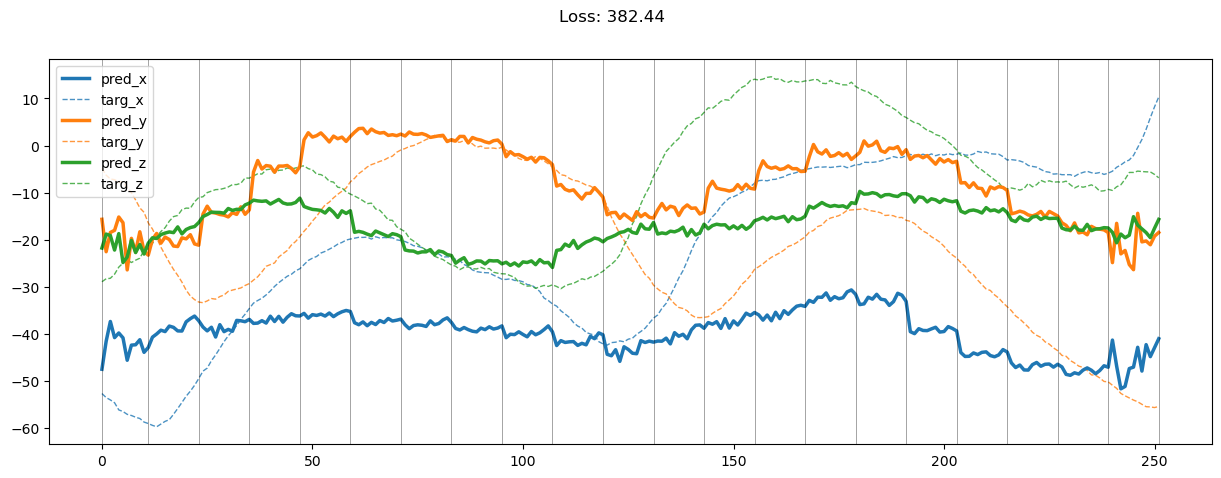

00039: train pred loss:  43.531, g loss:  257.154, diff loss:  84.099, d loss:  3.339
       valid pred loss:  305.658, g loss:  1410.372, diff loss:  491.423, d loss:  3.299


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.62it/s]


00040: train pred loss:  42.190, g loss:  249.412, diff loss:  81.495, d loss:  3.267
       valid pred loss:  285.278, g loss:  1416.108, diff loss:  558.156, d loss:  3.233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.64it/s]


00041: train pred loss:  42.087, g loss:  248.406, diff loss:  81.034, d loss:  3.213
       valid pred loss:  250.166, g loss:  1233.415, diff loss:  480.698, d loss:  3.189


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.69it/s]


00042: train pred loss:  43.583, g loss:  254.127, diff loss:  82.358, d loss:  3.178
       valid pred loss:  261.634, g loss:  1280.720, diff loss:  493.542, d loss:  3.165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.62it/s]


00043: train pred loss:  41.959, g loss:  238.609, diff loss:  76.205, d loss:  3.163
       valid pred loss:  247.648, g loss:  1239.552, diff loss:  494.325, d loss:  3.163


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.56it/s]


00044: train pred loss:  36.903, g loss:  218.526, diff loss:  71.225, d loss:  3.168
       valid pred loss:  266.886, g loss:  1305.378, diff loss:  502.471, d loss:  3.176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.60it/s]


00045: train pred loss:  36.363, g loss:  213.750, diff loss:  69.405, d loss:  3.191
       valid pred loss:  260.520, g loss:  1301.484, diff loss:  517.752, d loss:  3.210


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.63it/s]


00046: train pred loss:  34.531, g loss:  205.412, diff loss:  67.113, d loss:  3.231
       valid pred loss:  284.537, g loss:  1407.194, diff loss:  551.521, d loss:  3.258


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.66it/s]


00047: train pred loss:  33.910, g loss:  199.206, diff loss:  64.691, d loss:  3.285
       valid pred loss:  265.490, g loss:  1292.853, diff loss:  494.453, d loss:  3.321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.63it/s]


00048: train pred loss:  32.314, g loss:  195.271, diff loss:  64.387, d loss:  3.351
       valid pred loss:  296.010, g loss:  1480.807, diff loss:  590.988, d loss:  3.392


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.61it/s]


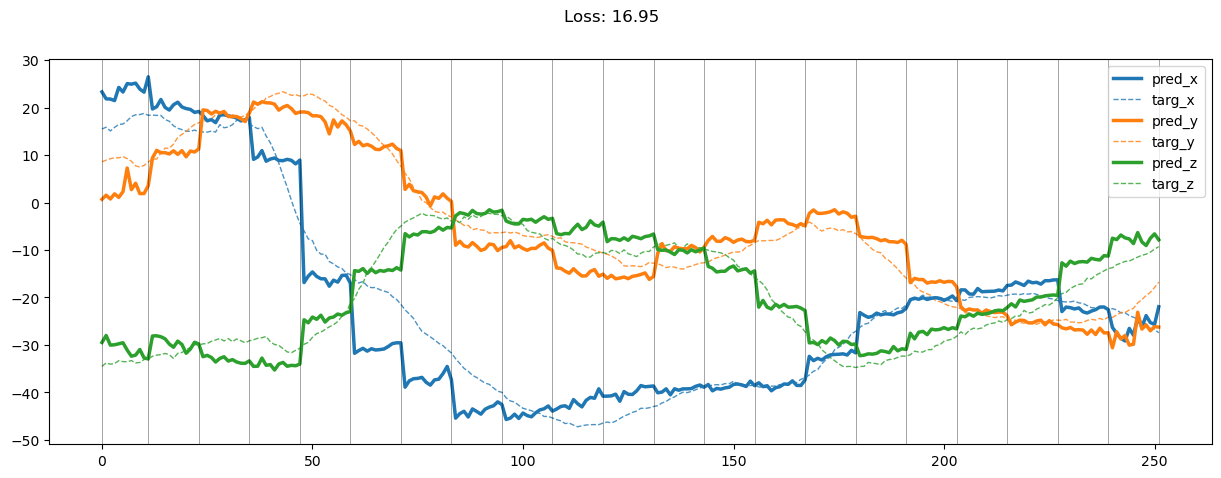

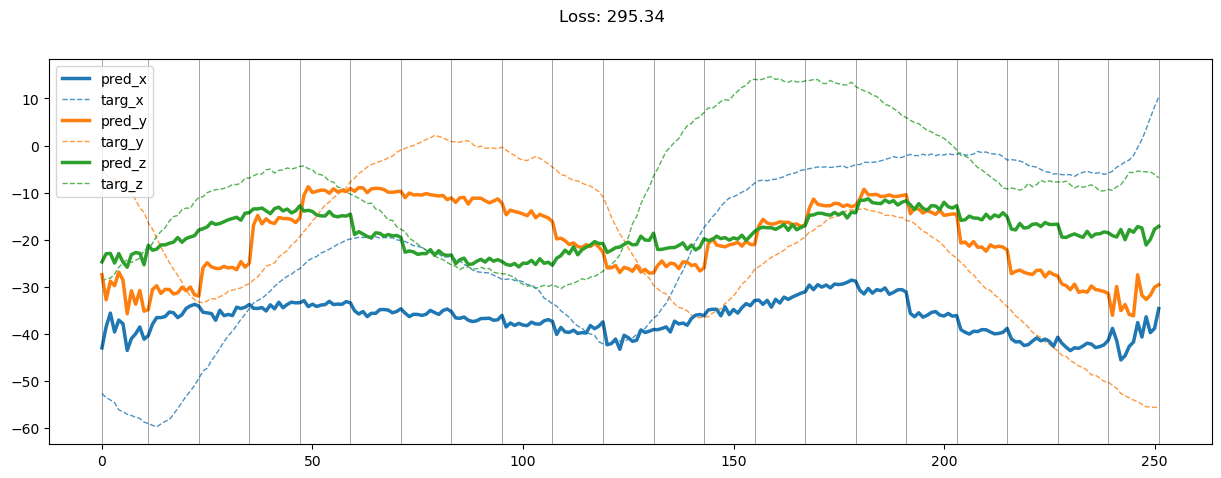

00049: train pred loss:  31.816, g loss:  186.433, diff loss:  60.537, d loss:  3.427
       valid pred loss:  269.358, g loss:  1306.488, diff loss:  496.770, d loss:  3.473


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.71it/s]


00050: train pred loss:  30.606, g loss:  181.787, diff loss:  59.497, d loss:  3.511
       valid pred loss:  328.958, g loss:  1613.680, diff loss:  625.306, d loss:  3.560


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.66it/s]


00051: train pred loss:  33.187, g loss:  193.411, diff loss:  62.799, d loss:  3.601
       valid pred loss:  301.683, g loss:  1424.320, diff loss:  517.908, d loss:  3.654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.67it/s]


00052: train pred loss:  32.100, g loss:  190.233, diff loss:  62.364, d loss:  3.696
       valid pred loss:  332.269, g loss:  1622.569, diff loss:  624.530, d loss:  3.750


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.70it/s]


00053: train pred loss:  32.471, g loss:  194.863, diff loss:  64.370, d loss:  3.793
       valid pred loss:  299.888, g loss:  1436.753, diff loss:  535.974, d loss:  3.848


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.59it/s]


00054: train pred loss:  36.645, g loss:  206.314, diff loss:  65.979, d loss:  3.892
       valid pred loss:  360.985, g loss:  1648.654, diff loss:  564.694, d loss:  3.949


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.70it/s]


00055: train pred loss:  34.457, g loss:  202.562, diff loss:  66.343, d loss:  3.992
       valid pred loss:  322.175, g loss:  1527.026, diff loss:  559.593, d loss:  4.048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.71it/s]


KeyboardInterrupt: 

In [43]:
draw = True

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 10 == 0:
        draw = True
    
    train_pred_loss, train_g_loss, train_diff_loss, train_d_loss = train(train_loader, draw)
    valid_pred_loss, valid_g_loss, valid_diff_loss, valid_d_loss = evalute(valid_loader, draw)
    
    draw = False
    
    ep = str(epoch).zfill(5)
    print(f'{ep:>5}: train pred loss: {train_pred_loss: 2.3f}, g loss: {train_g_loss: 2.3f}, diff loss: {train_diff_loss: 2.3f}, d loss: {train_d_loss: 2.3f}\n' +
          f'{"":>5}  valid pred loss: {valid_pred_loss: 2.3f}, g loss: {valid_g_loss: 2.3f}, diff loss: {valid_diff_loss: 2.3f}, d loss: {valid_d_loss: 2.3f}')

In [ ]:
draw = True
    
train_pred_loss, train_g_loss, train_diff_loss, train_d_loss = train(train_loader, draw)
valid_pred_loss, valid_g_loss, valid_diff_loss, valid_d_loss = evalute(valid_loader, draw)

draw = False

ep = str(epoch).zfill(5)
print(f'{ep:>5}: train pred loss: {train_pred_loss: 2.3f}, g loss: {train_g_loss: 2.3f}, diff loss: {train_diff_loss: 2.3f}, d loss: {train_d_loss: 2.3f}\n' +
      f'{"":>5}  valid pred loss: {valid_pred_loss: 2.3f}, g loss: {valid_g_loss: 2.3f}, diff loss: {valid_diff_loss: 2.3f}, d loss: {valid_d_loss: 2.3f}')

In [ ]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            target_data = target_data.to(device)

            #############
            # generator #
            #############
            predict_mag = model(source_data[:, :, :, :9], source_data[:, :, :, 9:12])

            predict_loss = mse_loss(predict_mag, target_data[:, :, :, 9:12])
            
            results.extend(zip(predict_mag.detach().cpu().numpy(), target_data[:, :, :, 9:12].cpu().numpy()))
            
            break
    
    return np.array(results)

In [ ]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [ ]:
results = output_eval(model, train_loader)

print(results.shape)

for rs in results[::5]:
    plot_result(rs)

In [ ]:
results = output_eval(model, valid_loader)

print(results.shape)

for rs in results[::5]:
    plot_result(rs)